# Apple Stock Price Prediction Project

I collected data on Apple stock prices from 2012 to 2021. The data was downloaded from Yahoo Finance and was analyzed. The dataset has 2,435 rows and 6 columns. The data set comprises the opening stock price, highest price reached, lowest price, and closing price. Also, the adjusting closing price to reflect other factors like dividends, stock splits, and other information are mentioned in the columns of our dataset. Similarly, volume represents the total number of shares traded during the trading session. 

Now, let us dive into our project. 

## Step 1: Data Scraping and Initial Analysis

In [25]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import yfinance as yf #should install yfinace first
yf.pdr_override()

In [26]:


# Specify the ticker symbol, start date, and end date
ticker = 'AAPL'
start_date = '2012-01-01'
end_date = '2021-09-05'

# Fetch data using yfinance directly
data = yf.download(ticker, start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed


In [27]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.416983,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.483714,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.622307,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.754256,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.734028,394024400
...,...,...,...,...,...,...
2021-08-30,149.000000,153.490005,148.610001,153.119995,150.772461,90956700
2021-08-31,152.660004,152.800003,151.289993,151.830002,149.502258,86453100
2021-09-01,152.830002,154.979996,152.339996,152.509995,150.171829,80313700


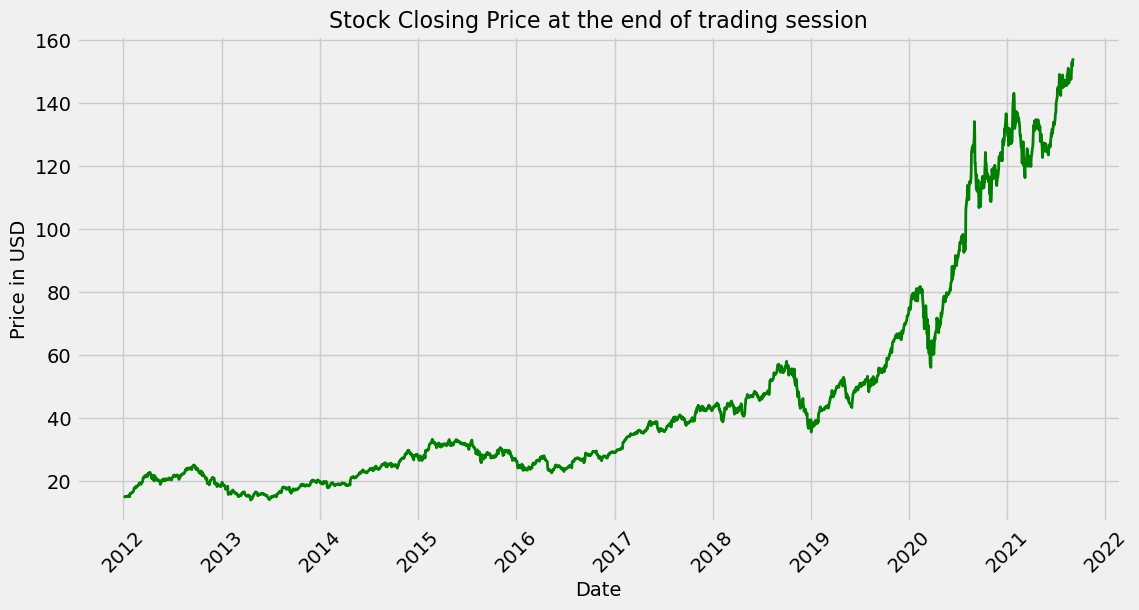

In [28]:
#Visualization of the closing price of stock at the end of the trading session. 

# Set the size of the plot to 14 inches by 8 inches for better readability
plt.figure(figsize=(12,6))

# Set the title of the plot with a larger font size
plt.title('Stock Closing Price at the end of trading session', fontsize=16)

# Label the y-axis as 'Price in Dollar' with a larger font size
plt.ylabel('Price in USD', fontsize=14)

# Label the x-axis as 'Date' with a larger font size
plt.xlabel('Date', fontsize=14)

# Plot the 'Close' column from the 'data' DataFrame with a thicker line for better visibility
plt.plot(data['Close'], color = 'green', linewidth=2)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a grid to the plot for better readability of data points
plt.grid(True)

# Display the plot
plt.show()

## Step 2: Preprocessing and training the data for LSTM Modelling

In [29]:
# Extracting only the closing price data
data_cl = data[['Close']]
close_data = data_cl.values

# Calculating the length of the training data, which is 80% of the total closing data, and rounding up to the nearest integer
training_data_len = math.ceil(len(close_data) * 0.8)

# Printing the length of the training data (80% of the total closing data)
print(f"Training data length (80% of total): {training_data_len}")

# Printing the total length of the closing price data
print(f"Total length of closing data: {len(close_data)}")

Training data length (80% of total): 1948
Total length of closing data: 2435


In [30]:
# Initialize the MinMaxScaler to normalize the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the closing price data to normalize it
scaled_data = scaler.fit_transform(close_data)

# Print the first few rows of the scaled data for verification
print(scaled_data[:5])

[[0.00526735]
 [0.0058297 ]
 [0.00699768]
 [0.00810968]
 [0.00793919]]


We can see that the data is scaled/normalized between the range of 0 and 1.

In [31]:
# Create training data sets
# The training data consists of 80% of the normalized closing price data
train_data = scaled_data[0:training_data_len, :]

# Initialize empty lists to store the sequences (x_train) and corresponding target values (y_train)
x_train = []
y_train = []

# Loop through the training data to create sequences of 60 time steps and the corresponding target value
for i in range(60, len(train_data)):
    # Append a sequence of the previous 60 days' closing prices to x_train
    x_train.append(train_data[i-60:i, 0])
    # Append the target value (the next day's closing price) to y_train
    y_train.append(train_data[i, 0])

# Print the number of sequences created
print(len(x_train))

1888


In [32]:
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1)) #Forming columns of no. of samples, number of time steps, and number of features
# x_train are the number of rows. This format is suitable for feeding into LSTM model for training and prediction in time-series forecasting tasks.


## Step 3: Implementing LSTM for the price prediction

In [33]:
# Initialize the sequential model
model = Sequential()

# Define the input shape explicitly
model.add(Input(shape=(x_train.shape[1], 1)))

# Add the first LSTM layer with 50 memory units and return sequences
model.add(LSTM(50, return_sequences=True))

# Add the second LSTM layer with 50 memory units (default: return_sequences=False)
model.add(LSTM(50))

# Add a dense layer with 25 neurons
model.add(Dense(25))

# Add the output layer with 1 neuron
model.add(Dense(1))

# Compile the model with Adam optimizer and mean squared error loss
model.compile(optimizer='adam', loss='mean_squared_error')

# Print a summary of the model architecture
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
#Training the model
model.fit(x_train,y_train,batch_size=1,epochs=1)

1888/1888 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - loss: 4.9283e-04


In [42]:
# Selecting the test data, starting from 20% of the dataset
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = close_data[training_data_len:, :]  # Selecting the actual closing prices for the test data

# Creating input sequences (x_test) for the LSTM model
sequence_length = 60  # Length of the input sequences (should match the model's input shape)

# Iterating through the test data to create input sequences
for i in range(sequence_length, len(test_data)):
    # Append a sequence of length 'sequence_length' ending at index 'i'
    x_test.append(test_data[i - sequence_length:i, 0])  # Assuming the data is univariate (only one feature)

# Convert x_test and y_test to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

In [43]:
# Reshape x_test to match the input shape expected by the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Print the shape of x_test to verify the reshaping
print("Shape of x_test after reshaping:", x_test.shape)

Shape of x_test after reshaping: (487, 60, 1)


In [37]:
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions) #to get the real closing price after inverse. Previously, min-max scaler had normalized the value. 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


We can see here that the prediction is 100%. Input is equal to output. 

## Step 4: Analysis of Predicted Stock Price

In [38]:
#root mean squre error calculation
rm=np.sqrt((np.mean(predictions-y_test)**2))
print(rm)

3.806880394780905


/var/folders/mb/341xckhs7959rycymd4br3380000gn/T/ipykernel_92072/3877727505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions.copy()


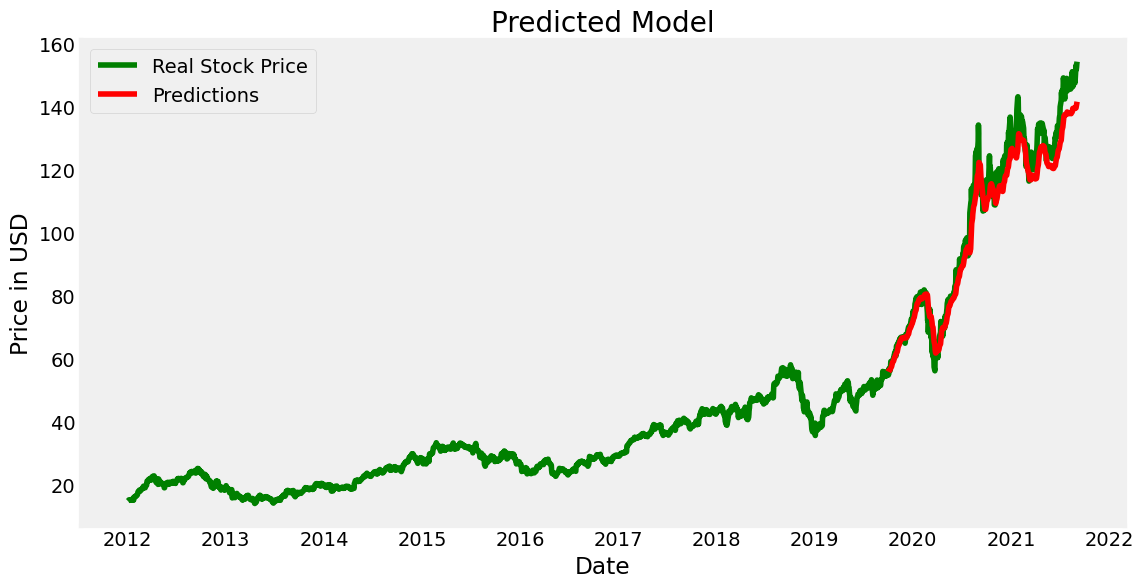

In [61]:
# Define training data as the closing price data
train = data_cl

# Select the remaining 20% of data for validation
valid = data_cl[training_data_len:]

# Add predictions to a new 'predictions' column in 'valid' DataFrame
valid['predictions'] = predictions.copy()

# Plotting the predicted model
plt.figure(figsize=(12, 6), facecolor = 'white')
plt.title('Predicted Model')
plt.xlabel('Date')
plt.ylabel('Price in USD')

# Plotting real stock prices and predictions
plt.plot(train['Close'], color = 'green', label='Real Stock Price')
plt.plot(valid['predictions'], color = 'red', label='Predictions')

# Display legend
plt.legend()

plt.grid(False)

# Show the plot
plt.show()

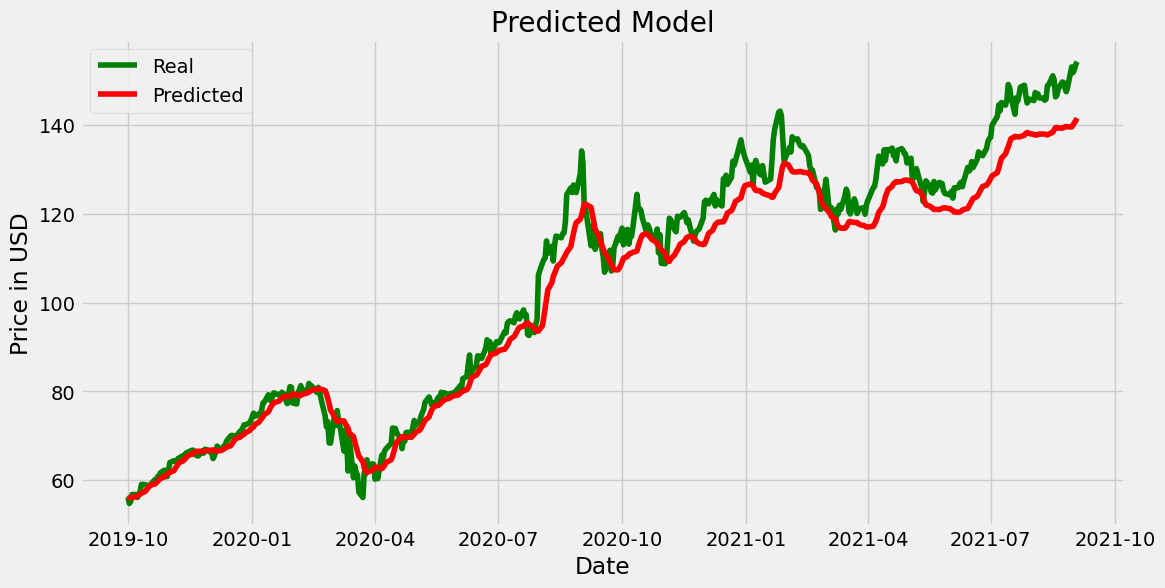

In [59]:
plt.figure(figsize=(12, 6))  # Create a figure with a size of 12x6 inches
plt.title('Predicted Model')  # Set the title of the plot
plt.xlabel('Date')  # Label the x-axis as 'Date'
plt.ylabel('Price in USD')  # Label the y-axis as 'Price in USD'

# Plot the real closing prices with a specific color (blue)
plt.plot(valid['Close'], color='green', label='Real')

# Plot the predicted prices with a specific color (green)
plt.plot(valid['predictions'], color='red', label='Predicted')

plt.legend()  # Add a legend to differentiate between real and predicted prices
plt.show()  # Display the plot

In this code, we can see that the real value of the stock price of apple is similar to the predicted stock price. The root mean square between real and the predicted value is 3.8. Thus, the goal of my project to predict the stock price is achieved. 